# Get timeseries of F0s
- Measures every 10 ms
- Needs to be extended to multiple wav files
- Need to add filename somehow as a feature, to keep track

In [1]:
import os
import pandas as pd
import numpy as np
from Tkinter import *
import tkSnack
root = Tk()
tkSnack.initializeSnack(root)

import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.externals.joblib import Memory
memory = Memory(cachedir="cache")


C:\Python27\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
##from pylab import *
@memory.cache
def getSound(fname_list):
    pitch_list = []
    for item in fname_list:
        utterance = tkSnack.Sound()
        utterance.read(item)
        utterance.convert(channels=1)
        pitch_tuple = utterance.pitch(method="ESPS", windowlength = 0.010)
        pitch_list.append(pitch_tuple)
        utterance.destroy()
    return pitch_list



path = "c:/Python27/qp2_py/dev50wav/"
#path = "c:/Python27/qp2_py/data/"
allWavs = os.listdir(path)
#allTxtgridsCOMB = [item for item in allFiles if item[0]== "C"]
#allWavs = [item for item in allFiles if item[0] !="C"]

allPaths = []
for item in allWavs:
    total_path = path+item
    allPaths.append(total_path)


    
#fname = [non_fname, native_fname]
pitch_list = getSound(allPaths)

In [3]:
print len(pitch_list)

50


# To Do:
- In this cell, get all of the name of files for baseline / test v train split

In [4]:
### Make a list of lists of F0 points

all_f0s_list = []
for item in pitch_list:
    just_f0_list = [j[0] for j in item]
    all_f0s_list.append(just_f0_list)


    
print len(all_f0s_list)


## output is [[series of f0s for one file][series of f0s for next file]] etc 




50


## Make TextGrid Objects
- Also needs to be extended to multiple files
- Edit this if you want to look at tiers other than IPU tiers (like Question Tiers)

In [5]:

import tgt
#non_txtgrd = "c:/Python27/qp2_py/txtgrids/COMBINE_p452p453-part2_ch1.textgrid"
#native_txtgrd = "c:/Python27/qp2_py/txtgrids/p226p227-part2_ch2.textgrid"
#all_txtgrids = [non_txtgrd, native_txtgrd]

allTxtPaths = []
path = "c:/Python27/qp2_py/dev50txtgrid/"
allTxtGrids = os.listdir(path)
for item in allTxtGrids:
    allTxtPaths.append(path+item)


checkGrid = allTxtPaths[0]
print len(allTxtPaths)

50


In [6]:
grid_obj= tgt.read_textgrid(checkGrid)
grid_obj.get_tier_names()


[u'BF',
 u'WORD',
 u'LONG_WORD',
 u'LONG_IPUs',
 u'IPU_WORDs',
 u'LAUGHTER',
 u'QUESTIONS']

# Combine TextGrids with F0s
- Has been extended (works)
- QUESTION:  Should we zscore normalize F0 later on, for Legendre coefficient modeling?
    - Yes, maybe.  Let's look at that today (5/31)

In [7]:
#annotations are a list of interval objects
inter = []
segmented_f0s = []

for i in range(len(allTxtPaths)):
    grid_obj = tgt.read_textgrid(allTxtPaths[i])
    word = grid_obj.get_tier_by_name('QUESTIONS')
    ipus = word.annotations
    length = len(ipus)
    for j in range(length):
        start = ipus[j].start_time
        end = ipus[j].end_time
        word = ipus[j].text
        #print start, end, word
        #multiply to get the correct index
        idx_start = int(start*100)
        idx_end = int(end*100)
        #print idx_start, idx_end
        f0s = all_f0s_list[i][idx_start:idx_end]
        entry = (start, end, f0s, word)
        inter.append(entry)
    segmented_f0s.append(inter)
    inter = []

    
    
print len(segmented_f0s)





## make this a loop
#first_word = word.annotations[0]
#print first_word.start_time
#print first_word.end_time
#print first_word.text
#returns a list of lists --> inner list is a tuple of (starttime, endtime, [listofF0series],"textstring")

50


## Code below deals with wavs with no questions
- Made notes of idx of who was removed 
- Still need to handle removing these from the labels, because they will not otherwise be aligned
    - NOT YET DONE AS OF 5/31 (Fix this ASAP)

In [18]:
########### THIS CODE REMOVES SPEAKERS WHO DO NOT HAVE ANY QUESTIONS, KEEPS TRACK OF WHO WAS REMOVED (IDX)#######
removed_idxs=[]
q_segmented_f0s = []

for i in range(len(segmented_f0s)):
    if len(segmented_f0s[i]) == 0:
        removed_idxs.append(i)
    else:
        q_segmented_f0s.append(segmented_f0s[i])
    #for thing in item:
     #   print thing[-1]

print removed_idxs
print len(q_segmented_f0s)

[9, 16, 17, 19, 22, 26, 39, 42, 47]
41


## Redo baseline w/ removed speakers

In [19]:
###NOTES ABOUT THIS FUNCTION: 
## Extended for large data lists (2/16/2016)
## log normalizes each F0 point in the IPU, then calculates min, max, and std of the normalized F0s
## also calculates mean and the z-normalized mean of the logF0 points per IPU
## currently (2/15/2016) returns a list of (ipuString, [seconds, minF0, maxF0, std, meanF0, znorm_meanF0, whisper])
## Goal is to output format that's good for sklearn
## NOTE:  For whispered ipus, all values are "NaN"
## NOTE: For one F0 point ipus, min, max, and mean F0 features are log of the F0 point, std&znorm are NaN, whisper = 0


## QUESTIONS FOR ANDREW (2/3/2016):
### z-normalized is returning between 1 and -1, is that okay?
## Is the normalization I'm doing okay
## can I z-score normalize already log normalized f0 means?
## QUESTIONS 2/15/2016
## is my zscore normalization correct?
## handling whisperes and f0 points okay?



#### segmented_f0s

#segmented_f0s is a list [start_time, end_time, [series of F0 measures every 10ms], "ipu_string"]
import scipy
import math
from scipy import stats

feature_set = []
intermediate = []

for i in range(len(q_segmented_f0s)):
    current = q_segmented_f0s[i]
    for item in current:
    ## assign text, calculate length    
        txt = str(item[3])
        start_time = item[0]
        end_time = item[1]
        time = end_time-start_time

        f0s = item[2]
        ## log of all valid f0 points
        logF0s = [math.log(f0) for f0 in f0s if f0 !=0]
        ##### if no F0 points
        if bool(logF0s) == False:
            minF0 = "NaN"
            maxF0 = "NaN"
            std = 0
            meanF0 = 0
            znorm_mean = 0
            whisper = 1
        ## if only 1 F0 value    
        elif len(logF0s) == 1:
            oneVal = math.log(logF0s[0])
            minF0 = oneVal
            maxF0 = oneVal
            std = 0
            meanF0 = oneVal
            znorm_mean = 0
            whipser = 0
        
        else:
            minF0 = min(logF0s)
            maxF0 = max(logF0s)
            meanF0 = sum(logF0s)/len(logF0s)
            std = scipy.stats.tstd(logF0s)
            for point in logF0s:
                znorm_mean = (point-meanF0)/std
            whisper = 0
        #print "min:%f, max:%f, std:%f, mean:%f, znormMean:%f" %(minF0, maxF0, std, meanF0, znorm_mean)

        features = [time, minF0, maxF0, std, meanF0, znorm_mean, whisper]
        set_tup = (txt, features)
        intermediate.append(set_tup)
    feature_set.append(intermediate)
    intermediate = []

print len(feature_set)
#for i in range(len(feature_set)):
#    print len(feature_set[i])

41


In [20]:
print feature_set[0]

[('WH', [2.3936694158080547, 4.16603184265473, 5.130416115834562, 0.23771509111643624, 4.802411028539697, -2.5544337701045814, 0]), ('Y/N', [1.8443018957335546, 4.442193388012666, 5.1370679699205235, 0.1053365462190093, 4.96006578581742, -4.9163601465347604, 0]), ('WH', [1.3341758394668268, 4.014318617883265, 4.956973281109724, 0.23105994762009349, 4.615646417337836, 0.12943011571901536, 0]), ('CLARIFYING', [3.4531594257368283, 3.9969678998560867, 5.295848348128665, 0.18446370063420123, 4.614431632920909, 1.537109639894471, 0]), ('WH', [2.4917684492532786, 4.020414749903103, 5.224134095304151, 0.19568833044331999, 4.643952374049284, 1.8305470784888851, 0]), ('XOR', [3.767081867690898, 4.453487910491439, 5.13309982765597, 0.15756766107361059, 4.80983967592601, 1.8975784164513954, 0]), ('XOR', [2.786070753457679, 3.99182513522434, 4.706559953282435, 0.1617351623476124, 4.382444835081891, 0.29319940088272933, 0]), ('WH', [3.904423098155462, 4.303937653575428, 5.10348179997476, 0.163756552

In [23]:
time_per_speaker = []
minf0_per_speaker = []
maxF0_per_speaker = []
meanf0_per_speaker = []
meanStd_per_speaker = []
meanZnorm_per_speaker = []
whispers_per_speaker = []



time = 0
meanf0_sum = 0
meanstd_sum = 0
meanZnorm_sum = 0
whisper_tot = 0

mins = []
maxs = []

[7.692307692307751, 4.778437317477203, 5.349490509827351, 0.17253538730659007, 4.908782448256691, -0.087913055167218049, 0]
[2.3936694158080547, 4.16603184265473, 5.130416115834562, 0.23771509111643624, 4.802411028539697, -2.5544337701045814, 0]


for speaker_ipus in feature_set:
    num_ipus = len(speaker_ipus)
    for item in speaker_ipus:
        secs = item[1][0]
        #print syls
        min_check =item[1][1]
        if min_check !="NaN":
            mins.append(min_check)
        max_check = item[1][2]
        if max_check != 'NaN':
            maxs.append(max_check)
        meanf0 = item[1][3]
        #print meanf0
        std = item[1][4]
        #print std
        znorm = item[1][5]
        #print znorm
        whisper = item[1][6]
        #print whisper
        ### calculate ######
        total_time = time+secs
        meanf0_sum = meanf0+meanf0_sum
        meanstd_sum = std+meanstd_sum
        meanZnorm_sum = znorm+meanZnorm_sum
        whisper_tot = whisper + whisper_tot
    
    #print maxs
    #calculate & reset
    
    time_speaker = total_time/num_ipus
    minF0 = min(mins)
    maxF0 = max(maxs)
    meanF0_speaker = meanf0_sum / num_ipus
    meanStd_speaker = meanstd_sum/ num_ipus
    meanZnorm_speaker = meanZnorm_sum/num_ipus
    
    print time_speaker, minF0, maxF0, meanF0_speaker, meanStd_speaker, meanZnorm_speaker, whisper_tot
    #### put them in out feature vectors
    time_per_speaker.append(time_speaker)
    minf0_per_speaker.append(minF0)
    maxF0_per_speaker.append(maxF0)
    meanf0_per_speaker.append(meanF0_speaker)
    meanStd_per_speaker.append(meanStd_speaker)
    meanZnorm_per_speaker.append(meanZnorm_speaker)
    whispers_per_speaker.append(whisper_tot)
    
    #### reset for next run###
    time =0
    meanf0_sum = 0
    meanstd_sum = 0
    meanZnorm_sum = 0
    whisper_tot = 0
    mins = []
    maxs = []
    

        

0.0401188012943 3.97952876911 6.3040398837 0.228747405033 4.73437783952 0.293287372528 0
0.0358157658112 3.97943227708 6.29383921633 0.298179140437 4.80434382227 0.425300549033 0
0.511398202279 4.46461809464 5.47889491331 0.200059218611 5.10068884433 1.07810631411 0
0.627847570434 4.03063584265 5.86418441373 0.500277642427 5.01841737664 1.64337810154 0
0.37278360937 4.05620802879 5.21005448543 0.116087763724 4.74926993028 0.861473125244 0
0.0117333333333 4.00275778988 6.2695299092 0.15066424402 4.85719026173 0.053661228031 0
0.521426954556 4.64142652472 5.73866302558 0.244155501121 5.31211326568 0.709377738897 0
4.0025281426 4.12486717877 5.2892879235 0.220740014672 4.84721607165 -0.282869628508 0
0.18 4.33118919308 4.81333529717 0.0834102151378 4.58243736746 -0.399002676864 0
1.79807185194 5.22941321009 5.54694970732 0.0743294018693 5.36575237122 -1.26868432094 0
0.924233305242 5.44426199199 5.94568348858 0.0763375382485 5.60599251447 4.44985497184 0
1.08293896286 3.99450334775 5.3785

In [25]:
####### make feature vector####
#########NOTE:  THIS DOES NOT USE WHISPERS, AND TIME IS CHANGED TO JUST LENGTH OF IPU ###########

features = pd.DataFrame(time_per_speaker, columns=["Seconds_per_IPU"])  ####CHECK - THIS MIGHT BE MILISECONDS
features["minF0"] = minf0_per_speaker
features["maxF0"]=maxF0_per_speaker
features["meanF0"] = meanf0_per_speaker
features["meanStd"] = meanStd_per_speaker
features["meanZnorm"] = meanZnorm_per_speaker


print features

    Second_per_IPU     minF0     maxF0    meanF0   meanStd  meanZnorm
0         0.040119  3.979529  6.304040  0.228747  4.734378   0.293287
1         0.035816  3.979432  6.293839  0.298179  4.804344   0.425301
2         0.511398  4.464618  5.478895  0.200059  5.100689   1.078106
3         0.627848  4.030636  5.864184  0.500278  5.018417   1.643378
4         0.372784  4.056208  5.210054  0.116088  4.749270   0.861473
5         0.011733  4.002758  6.269530  0.150664  4.857190   0.053661
6         0.521427  4.641427  5.738663  0.244156  5.312113   0.709378
7         4.002528  4.124867  5.289288  0.220740  4.847216  -0.282870
8         0.180000  4.331189  4.813335  0.083410  4.582437  -0.399003
9         1.798072  5.229413  5.546950  0.074329  5.365752  -1.268684
10        0.924233  5.444262  5.945683  0.076338  5.605993   4.449855
11        1.082939  3.994503  5.378539  0.281167  4.766262   0.582853
12        0.061695  3.980875  5.971275  0.301706  5.190935   0.296251
13        0.063584  

### Read in baseline, drop speakers without questions

In [76]:
######## OH GOD THIS WORKS FINALLY, THANK GOD ########

label_csv = pd.read_csv("c:/Python27/qp2_py/labels/devlabels50.csv")
print type (label_csv)

label_csv.drop(removed_idxs, inplace=True)
labels = label_csv.reset_index(drop=True)

labels = labels["Language"]

print labels


<class 'pandas.core.frame.DataFrame'>
0      English
1      English
2      English
3      English
4     Mandarin
5     Mandarin
6     Mandarin
7     Mandarin
8      English
9     Mandarin
10     English
11     English
12     English
13     English
14    Mandarin
15     English
16     English
17     English
18    Mandarin
19     English
20     English
21     English
22     English
23    Mandarin
24     English
25    Mandarin
26    Mandarin
27    Mandarin
28    Mandarin
29    Mandarin
30    Mandarin
31    Mandarin
32    Mandarin
33    Mandarin
34    Mandarin
35    Mandarin
36    Mandarin
37    Mandarin
38    Mandarin
39    Mandarin
40     English
Name: Language, dtype: object


In [34]:
## Okay let's fix the labeling / features problem
### It's fixed!  This will 
infeatures = pd.read_csv("c:/Python27/qp2_py/features_for_models/baseline_50.csv")
del infeatures['Unnamed: 0']
infeatures.drop(removed_idxs, inplace=True)
baseline_features= infeatures.reset_index(drop=True)

print baseline_features

    Syl_Per_Speaker     minF0     maxF0    meanF0   meanStd  meanZnorm  \
0          4.449733  1.642243  6.305370  0.186416  4.609855  -0.186544   
1          3.726221  3.979432  6.293839  0.247727  4.804718  -0.150966   
2          3.366413  3.979326  6.288945  0.247534  5.017004  -0.289292   
3          2.982662  3.983007  6.281454  0.241353  5.119777  -0.406997   
4          3.803746  3.978059  5.735466  0.140937  4.738914  -0.137249   
5          4.252642  3.981037  6.287604  0.140054  4.754662  -0.226808   
6          3.345361  3.975805  6.276253  0.282529  5.079049   0.034359   
7          3.803029  3.980178  6.188084  0.144884  4.762278   0.189347   
8          4.506203  3.978750  6.245704  0.100664  4.513169   0.153678   
9          2.948516  3.979934  6.244384  0.213999  5.098003  -0.229735   
10         3.373189  3.978571  6.281436  0.190771  5.265107   0.370599   
11         4.406870  3.977100  5.940593  0.160052  4.663480  -0.324910   
12         3.537813  3.978820  5.97127

In [36]:
import numpy
from numpy.polynomial import Legendre as L
#sklearn polynomial fitting function
# each polynomial as a feature
#average degree polynomial value per speaker
print len(q_segemnted_f0s)

inter = []
ipu_f0s = []

for wavfile in q_segemnted_f0s:
    for ipu in wavfile:
        if ipu[3] == "silent":
            pass
        else:
            inter.append(ipu)
    ipu_f0s.append(inter)
    inter = []

print len(ipu_f0s)

41
41


In [37]:
### takes lists of IPUs per speaker, creates 5 degree Legendre polynomial coefficients for each IPU,
### result is a matching list with an inner list of legendre transformed ipus

import numpy
from numpy.polynomial import Legendre as L
#sklearn polynomial fitting function
# each polynomial as a feature
#average degree polynomial value per speaker
print len(q_segemnted_f0s)


degree = 5

Xtimes = []
legendre_list = []
inter_l = []
time = []
count = 0
for ipu in ipu_f0s:
    for i in range(len(ipu)):
        start = ipu[i][0]
        end = ipu [i][1]
        f0s = ipu[i][2]
        x_time = []
        for j in range(len(f0s)):
            x_time.append(start+(0.01*j))
        fit = L.fit(x_time, f0s, degree)
        inter_l.append(fit)
        time.append(x_time)
    Xtimes.append(time)
    legendre_list.append(inter_l)
    inter_l = []  
    time = []
    #print count
    count = count+1
    fit = None
        

#print legendre_list[0][:10]

print len(legendre_list)
print len(Xtimes)


41
41
41


<class 'pandas.core.frame.DataFrame'>


In [78]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(baseline_features, labels, random_state=0)



logreg = LogisticRegression().fit(X_train, y_train)
score = logreg.score(X_test, y_test)

#classifier = linear_model.LogisticRegression()
#classifier = svm.LinearSVC()
#classifier.fit(X_train, y_train)
#score = classifier.score(X_test, y_test)
predicts = logreg.predict(X_test)

print score, predicts

### LinearSVC yeilds 61% accuracy here, LogReg is 76% (but it's a weird and imbalenced split)
### LinearSVC is probably better for this task

0.454545454545 ['English' 'English' 'Mandarin' 'English' 'Mandarin' 'Mandarin' 'English'
 'English' 'Mandarin' 'Mandarin' 'English']


In [36]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
line_svm = LinearSVC()

scores = cross_val_score(line_svm, data_features, labels, cv=10)
print("cross-validation scores: ", scores)
print scores.mean()

('cross-validation scores: ', array([ 0.5       ,  0.5       ,  0.66666667,  0.66666667,  1.        ,
        1.        ,  0.5       ,  0.5       ,  0.75      ,  0.75      ]))
0.683333333333


### Let's try with a ShuffleSplit cross validation and then fiddle with paramaters
- ShuffleSplit seems like the way to go here (yeilds between 50 and 63% accuracy, hovers mostly between 53-58
- Time to do some parameter tuning, I think.

In [37]:
from sklearn.cross_validation import ShuffleSplit
classifier = LogisticRegression()
shuffle_split = ShuffleSplit(50, n_iter= 10, test_size=.25, train_size=.75)
shuffle_score = cross_val_score(classifier, data_features, labels, cv=shuffle_split)
print shuffle_score.mean()

0.723076923077


### Let's do some motherfuckin' GridSearching of paramaters
- This is actually working pretty well.  If we use SVC (which is a kernel SVM, and SVMs are good) baseline is like 69%

In [43]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}



#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=10)

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, random_state=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'gamma': 1}
0.837837837838


### The model below performs the best, SVC with C and gamma set from running GridSearch above
- So my acoustic baseline performs around 70%, which is where it should be
- No idea why SVM works better than Linear SVC or LogisticRegession, except that I guess the data here is better divided by curves rather than divides by straight lines?  
- One day, visualizing any of this would be nice


In [46]:
classifier = SVC(C=10, gamma=1)
from sklearn.cross_validation import ShuffleSplit
shuffle_split = ShuffleSplit(50, n_iter= 10, test_size=.25, train_size=.75)
shuffle_score = cross_val_score(classifier, data_features, labels, cv=shuffle_split)
print shuffle_score.mean()

0.7


# Shifting gears: Add polynomial coefficient features

### Still need to do the following:
- Figure out how to add the coefficients as features 
    - talk to Min to figure this out?
    - SPEAKER BASED, NOT IPU BASED (no idea how to do that)
    
- Cluster all coefficients (unsupervised), use number of clusteres as a per speaker feature

- Use all coefficients from native / non-native speakers to train an unsupervised clusterer
    - then for each ipu per speaker get a distance measure to find closest cluster
    - assign ipu to cluster, use total # of each cluster as features (eg. 7 in cluseter 1, 8 in cluster 2)???
        - but how to do that unsupervised - there will be different numbers of clusters
    - replace ipus with distances to find a mean shortest distance to a cluster?
        - that's overgeneralized
    - average distance per cluster? (mean distance for ipus assigned to each cluster)
        - use these distances as features
        - still would need to be supervised clustering probably
        - but distnace would be a better measure of like-ness to native / non-native clusters than just amount

In [12]:
import numpy
from numpy.polynomial import Legendre as L
#sklearn polynomial fitting function
# each polynomial as a feature
#average degree polynomial value per speaker
print len(q_segemnted_f0s)

inter = []
ipu_f0s = []

for wavfile in q_segemnted_f0s:
    for ipu in wavfile:
        if ipu[3] == "silent":
            pass
        else:
            inter.append(ipu)
    ipu_f0s.append(inter)
    inter = []

print len(ipu_f0s)




16
16


In [15]:
#print ipu_f0s[49][74]

In [49]:
########## This code runs 49 speakers but dies on the 50th, write code below to handle one at a time.
import numpy
from numpy.polynomial import Legendre as L
fpath = "c:/Python27/qp2_py/legendre_polynomials/ipu_speaker"
degree = 5
count =0


for k in range(len(ipu_f0s)):
    speakerID = str(k)
    fname = fpath+speakerID+".txt"
    outfile = open(fname, "w")
    for i in range(len(ipu_f0s[k])):
        start = ipu_f0s[k][i][0]
        end = ipu_f0s[k] [i][1]
        f0s = ipu_f0s[k][i][2]
        x_time = []
        for j in range(len(f0s)):
            x_time.append(start+(0.01*j))
        fit = L.fit(x_time, f0s, degree)
        entry = str(fit)+"\n"
        outfile.write(entry)
    outfile.close()
    print "file %d has been written to %s"%(k, fname)
    #print count
    count = count+1
    fit = None

file 0 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker0.txt
file 1 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker1.txt
file 2 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker2.txt
file 3 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker3.txt
file 4 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker4.txt
file 5 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker5.txt
file 6 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker6.txt
file 7 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker7.txt
file 8 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker8.txt
file 9 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker9.txt
file 10 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker10.txt
file 11 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_sp

C:\Python27\lib\site-packages\numpy\polynomial\legendre.py:1588: RankWarning: The fit may be poorly conditioned
  warnings.warn(msg, pu.RankWarning)


fpath = "c:/Python27/qp2_py/legendre_polynomials/ipu_speaker"
speaker_ipu = ipu_f0s[49]
fname = fpath+"49"+".txt"
outfile = open(fname, "w")
degree = 5

for i in range(len(speaker_ipu)):
    start = speaker_ipu[i][0]
    end = speaker_ipu[i][1]
    f0s = speaker_ipu[i][2]
    words = speaker_ipu[i][3]
    print i
    x_time = []
    for j in range(len(f0s)):
        x_time.append(start+(0.01*j))
    fit = L.fit(x_time, f0s, degree)
    entry = str(fit)+"\n"
    outfile.write(entry)
outfile.close()
print "file %d has been written to %s"%(k, fname)
#fit = None

In [13]:
### takes lists of IPUs per speaker, creates 7 degree Legendre polynomial coefficients for each IPU,
### result is a matching list with an inner list of legendre transformed ipus

import numpy
from numpy.polynomial import Legendre as L
#sklearn polynomial fitting function
# each polynomial as a feature
#average degree polynomial value per speaker
print len(q_segemnted_f0s)


degree = 7

Xtimes = []
legendre_list = []
inter_l = []
time = []
count = 0
for ipu in ipu_f0s:
    for i in range(len(ipu)):
        start = ipu[i][0]
        end = ipu [i][1]
        f0s = ipu[i][2]
        x_time = []
        for j in range(len(f0s)):
            x_time.append(start+(0.01*j))
        fit = L.fit(x_time, f0s, degree)
        inter_l.append(fit)
        time.append(x_time)
    Xtimes.append(time)
    legendre_list.append(inter_l)
    inter_l = []  
    time = []
    #print count
    count = count+1
    fit = None
        

#print legendre_list[0][:10]

print len(legendre_list)
print len(Xtimes)



16
16
16


In [38]:
######## get the polynomial coefficients ################
## can get individual coefficients with .coef[idx]
####### FOLLOW THE FORMAT BELOW ######
## legendreitem = legendre_list[idx_of_file][ipu]
## degree from above

print len(legendre_list)
x =  legendre_list[0][0]
print x
print x.coef[1]

all_ipu_coefs = []
inter = []
for item in legendre_list:
    for i in range(len(item)):
        ipu = item[i]
        ipu_coefs = [ipu.coef[j] for j in range(degree)]
        inter.append(ipu_coefs)
    all_ipu_coefs.append(inter)
    inter = []
print len(all_ipu_coefs)

41
leg([ 104.13119311   10.26911515  -74.35533257  -17.64080039  -62.06122939
   37.96210899])
10.269115155
41


In [42]:
print len(Xtimes[0])

67


In [18]:
####### WRITE OUT FOR WEISE TO RUN FRECHET DISTANCE MEASURING CODE ON

print len(all_ipu_coefs)
print len(Xtimes)
fpath = "c:/Python27/qp2_py/legendre_polynomials/frechet/questions_AllSpeakers"

def CleanUp(entry):
    entry = str(entry)
    entry = entry.replace(",", " ")
    return entry

for i in range(len(Xtimes)):
    speakerID = str(i)
    fname = fpath+".txt"
    outfile = open(fname, "w")
    for j in range(len(Xtimes[i])):
        outfile.write("0:")
        time_entry = tuple(Xtimes[i][j])
        time_entry = CleanUp(time_entry)
        outfile.write(time_entry)
        outfile.write(":0 ")
        outfile.write("1:")
        coef_entry = tuple(all_ipu_coefs[i][j])
        coef_entry = CleanUp(coef_entry)
        outfile.write(coef_entry)
        outfile.write(":0 ")
    outfile.write("\n")
outfile.close()
print "your file has been written to %s" %(fname)
        

    

16
16
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_AllSpeakers.txt


In [16]:
############## FORMAT REVAMPED FOR WEISE ################
######## ALL KINDS OF NOT WORKING ############

print len(all_ipu_coefs)
sample_coefs = all_ipu_coefs[:2]
ys = [0,1]
print len(Xtimes)
fpath = "c:/Python27/qp2_py/legendre_polynomials/frechet/questions_sampformat1"

def CleanUp(entry):
    entry = str(entry)
    entry = entry.replace(",", " ")
    return entry

def AddYs(entry):
    outlist = []
    for item in entry:
        outlist.append(item)
        outlist.append(0)
    return outlist
    
####### PAUSED HERE, NEED ONE CURVE PER SPEAKER ########
for i in range(len(sample_coefs)):
    speakerID = str(i)
    fname = fpath+".txt"
    outfile = open(fname, "w")
    for j in range(len(sample_coefs[i])):
        outfile.write()
        coef_entry = tuple(all_ipu_coefs[i][j])
        coef_entry = tuple(AddYs(coef_entry))
        print coef_entry
        coef_entry = CleanUp(coef_entry)
        #outfile.write(coef_entry)
        #outfile.write(":0 ")
    #outfile.write("\n")
#outfile.close()
#print "your file has been written to %s" %(fname)
        

41
41
(104.13119311453136, 0, 10.269115154978408, 0, -74.355332569980902, 0, -17.640800389602926, 0, -62.061229391398825, 0)
(111.09537795714063, 0, 24.2343846556765, 0, -27.094823135570543, 0, 27.165877644696973, 0, -28.727349520916643, 0)
(69.85002418981729, 0, -9.4098067436909698, 0, -58.750983388727477, 0, 59.322371180466924, 0, -13.920485683294801, 0)
(67.588661149370083, 0, -8.5730212724008386, 0, 27.15815387526165, 0, 49.136098061043874, 0, -0.32330551941756597, 0)
(79.752055174999555, 0, 16.682410657261684, 0, -0.086871932696329451, 0, 19.258039184050581, 0, -35.538336234170799, 0)
(78.56449387485533, 0, -28.797999117676625, 0, -21.266875021134897, 0, -1.8081213511569032, 0, -36.428664039656006, 0)
(62.893075973136831, 0, -12.830002009388807, 0, -17.430254935420557, 0, -0.6575870745620398, 0, -36.301882016277588, 0)
(93.691008746949237, 0, -6.7323594997618939, 0, -29.025025676728539, 0, 4.2662980933172863, 0, 6.3467202579093556, 0)
(80.083031535853635, 0, -2.9281927590729091, 0

## Cell below fixes problems with data that had to be removed because there were no questions in the wav
- Below code can edit baselines and baselines with added features as well

# Build Clusters (below)

In [39]:
print len(all_ipu_coefs)

41


In [40]:
import numpy as np
all_L_stacked = np.vstack(all_ipu_coefs)
all_L_stacked.shape

##rows are each legendre coefficient ipu-representation, columns are each individual coefficient

(1214, 5)

In [41]:
all_L_stacked.std(axis=0)  ## use as a feature for per-speaker features, as well
### stds are widly different, so we could really benefit from some normalization, which we do in the next cell

array([ 37.31042571,  44.72610663,  50.92366764,  55.74334353,  55.99638039])

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(all_L_stacked)
scaledLstack = scaler.transform(all_L_stacked)
scaledLstack.std(axis=0)

array([ 1.,  1.,  1.,  1.,  1.])

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components =2)
pca.fit(scaledLstack)
pca_Legendres = pca.transform(scaledLstack)

<IPython.core.display.Javascript object>


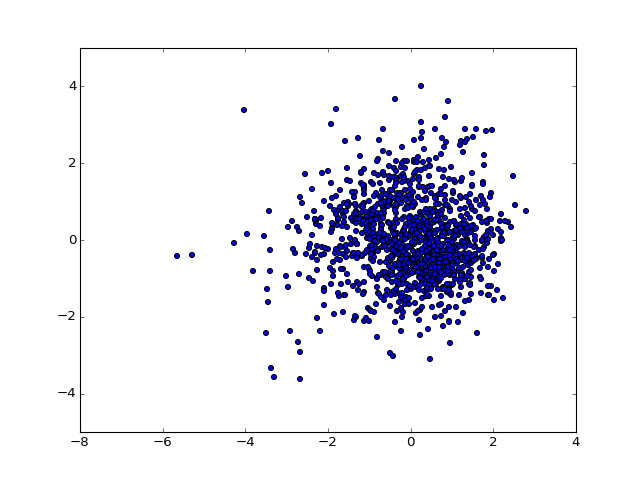

In [44]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.scatter(pca_Legendres[:,0],pca_Legendres[:,1])

##PCA Scatterplot of first and second principle components (dots are polynomials)

In [225]:
### Cluster the polynomials 
from sklearn.cluster import KMeans
#from sklearn.cluster import AgglomerativeClustering

cluster = KMeans(n_clusters=8)
#cluster = AgglomerativeClustering()

cluster.fit(scaledLstack)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [46]:
cluster.cluster_centers_
#cluster.labels_

array([[  2.66493873e-04,   5.50893107e-01,   9.19554480e-01,
          3.82343691e-01,   8.02062130e-01],
       [  7.26547353e-01,  -8.65213155e-01,  -4.63264465e-01,
         -2.05091816e-01,  -6.69207318e-01],
       [ -4.71153489e-01,   3.50470195e-01,  -5.83859021e-01,
         -1.16150328e+00,   7.11791625e-01],
       [ -1.00495282e+00,  -4.09764534e-01,   1.76618347e-01,
         -5.68777937e-02,   2.14110334e-01],
       [  1.06080507e+00,   4.39853786e-01,   2.84424367e-01,
          1.37594352e+00,  -3.41127918e-01],
       [  1.89834811e-01,  -6.71961447e-01,  -1.38525874e+00,
          8.35455122e-01,   7.01384001e-01],
       [  1.41599346e+00,   1.78249770e+00,  -6.82697670e-01,
         -8.23940561e-01,  -8.95062240e-01],
       [ -3.31979649e-02,   2.17491019e-01,   9.73348975e-01,
         -5.01713714e-01,  -1.14894879e+00]])

In [180]:
print len(cluster.labels_)
n_clusters = len(cluster.labels_)

1214


<IPython.core.display.Javascript object>


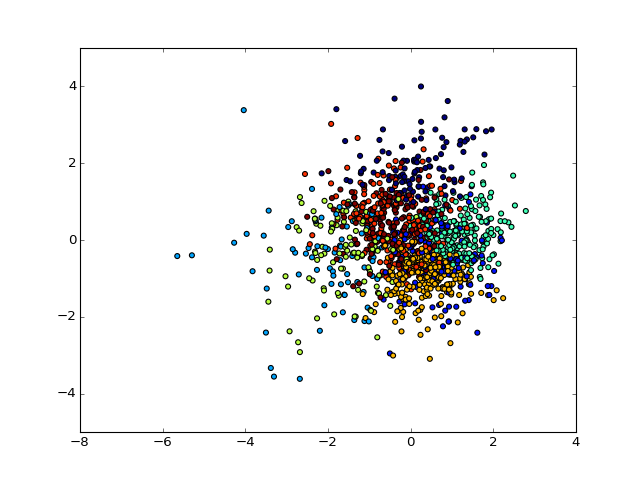

In [226]:
plt.figure()
plt.scatter(pca_Legendres[:,0],pca_Legendres[:,1], c=cluster.labels_)


In [227]:
speaker_ipu_histograms = []
for speaker in all_ipu_coefs:
    scaled_ipu = scaler.transform(speaker)
    ipu_centers = cluster.predict(scaled_ipu)
    histo = np.bincount(ipu_centers, minlength=cluster.n_clusters) #set to to the clusteres we specificied before 
    #histo = np.bincount(ipu_centers, minlength=cluster.n_clusters) #set to to the clusteres we specificied before 
    speaker_ipu_histograms.append(histo / float(histo.sum()))

In [183]:
print speaker_ipu_histograms[0]

[ 0.01492537  0.82089552  0.11940299  0.04477612]


<IPython.core.display.Javascript object>


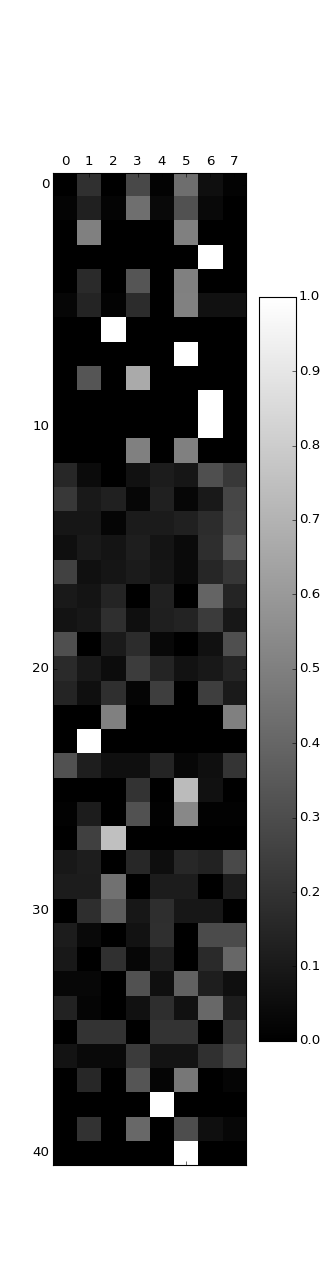

<matplotlib.colorbar.Colorbar instance at 0x3529A080>

In [228]:
speaker_ipu_histograms

plt.matshow(speaker_ipu_histograms,cmap="gray")
plt.colorbar()
#cmap="viridis"

<IPython.core.display.Javascript object>


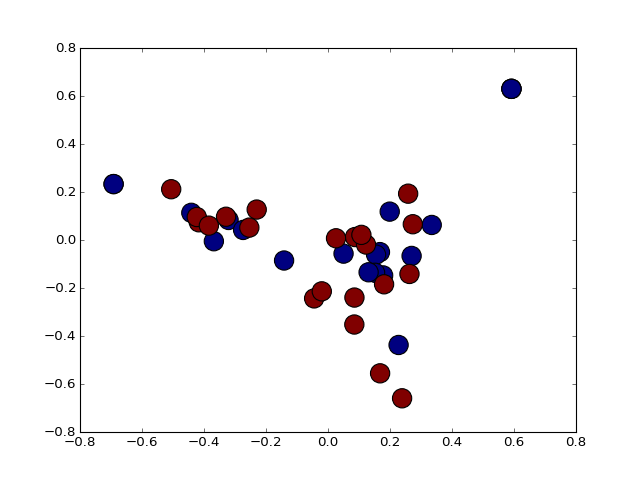

In [229]:
pca = PCA(n_components =2)
pca.fit(speaker_ipu_histograms)
pca_Histograms = pca.transform(speaker_ipu_histograms)
plt.figure()
plt.scatter(pca_Histograms[:,0],pca_Histograms[:,1], c=np.array(labels)=="Mandarin", s=300)

#######histogram scatterplot of what these things look like - needs a list of labels#

In [55]:
np.array(labels) == "Mandarin"

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False, False],
       [False, False, False,  True],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True],
       [False, False, False, False],
       [False, False, False,  True],
       [False, False, False,  True],
 

# Add Legendre polynomial cluster histograms as features to baseline
## And then classify

In [230]:
### create feature vectors for each cluster for each speaker out of the histograms
legendre_features = pd.concat([baseline_features,pd.DataFrame(speaker_ipu_histograms, columns=["cluster%d" % i for i in range(8)])], axis=1)

In [58]:
legendre_features

,Syl_Per_Speaker,minF0,maxF0,meanF0,meanStd,meanZnorm,Total_Whispered,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
0,4.449733,1.642243,6.305370,0.186416,4.609855,-0.186544,12,0.164179,0.014925,0.208955,0.567164,0.000000,0.014925,0.000000,0.029851
1,3.726221,3.979432,6.293839,0.247727,4.804718,-0.150966,8,0.150943,0.000000,0.169811,0.509434,0.037736,0.056604,0.018868,0.056604
2,3.366413,3.979326,6.288945,0.247534,5.017004,-0.289292,0,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.982662,3.983007,6.281454,0.241353,5.119777,-0.406997,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3.803746,3.978059,5.735466,0.140937,4.738914,-0.137249,2,0.166667,0.000000,0.166667,0.333333,0.000000,0.000000,0.000000,0.333333
5,4.252642,3.981037,6.287604,0.140054,4.754662,-0.226808,6,0.253333,0.040000,0.200000,0.320000,0.000000,0.040000,0.000000,0.146667
6,3.345361,3.975805,6.276253,0.282529,5.079049,0.034359,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
7,3.803029,3.980178,6.188084,0.144884,4.762278,0.189347,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
8,4.506203,3.978750,6.245704,0.100664,4.513169,0.153678,1,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000
9,2.948516,3.979934,6.244384,0.213999,5.098003,-0.229735,3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [231]:
only_legendre = pd.DataFrame(speaker_ipu_histograms, columns=["cluster%d" % i for i in range(8)])
#print only_legendre


In [232]:
###add it to the baseline
feature_columns = [col for col in list(legendre_features.columns) if col!= "labels"]
baseline_legendre =(legendre_features[feature_columns])
#print baseline_legendre

In [233]:
baseline_legendre.to_csv("c:/Python27/qp2_py/features_for_models/baseline_questionlegendre_k8.csv")

In [79]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

In [128]:
print len(only_legendre)
print len(labels)

41
41


In [66]:
baseline_legendre

,Syl_Per_Speaker,minF0,maxF0,meanF0,meanStd,meanZnorm,Total_Whispered,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
0,4.449733,1.642243,6.305370,0.186416,4.609855,-0.186544,12,0.164179,0.014925,0.208955,0.567164,0.000000,0.014925,0.000000,0.029851
1,3.726221,3.979432,6.293839,0.247727,4.804718,-0.150966,8,0.150943,0.000000,0.169811,0.509434,0.037736,0.056604,0.018868,0.056604
2,3.366413,3.979326,6.288945,0.247534,5.017004,-0.289292,0,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.982662,3.983007,6.281454,0.241353,5.119777,-0.406997,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3.803746,3.978059,5.735466,0.140937,4.738914,-0.137249,2,0.166667,0.000000,0.166667,0.333333,0.000000,0.000000,0.000000,0.333333
5,4.252642,3.981037,6.287604,0.140054,4.754662,-0.226808,6,0.253333,0.040000,0.200000,0.320000,0.000000,0.040000,0.000000,0.146667
6,3.345361,3.975805,6.276253,0.282529,5.079049,0.034359,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
7,3.803029,3.980178,6.188084,0.144884,4.762278,0.189347,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
8,4.506203,3.978750,6.245704,0.100664,4.513169,0.153678,1,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000
9,2.948516,3.979934,6.244384,0.213999,5.098003,-0.229735,3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [244]:
#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
#              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

from sklearn.grid_search import GridSearchCV
#from sklearn.svm import SVC
#grid_search = GridSearchCV(SVC(), param_grid, cv=10)

from sklearn.svm import LinearSVC
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=10)


X_train, X_test, y_train, y_test = train_test_split(only_legendre, labels, random_state=0)


grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.001}
0.533333333333


In [189]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.svm import SVC
classifier = SVC(C=1, gamma= 1)

X_train, X_test, y_train, y_test = train_test_split(only_legendre, labels, random_state=0)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print score



0.363636363636


In [240]:
#data_features = baseline alone
#baseline_legendres = baseline + legendre

from sklearn.cross_validation import ShuffleSplit
from sklearn.svm import SVC
classifier = SVC(C=.001, gamma=.001)


from sklearn.cross_validation import ShuffleSplit
shuffle_split = ShuffleSplit(41, n_iter= 10, test_size=.25, train_size=.75)

shuffle_score = cross_val_score(classifier, only_legendre, labels, cv=shuffle_split)
print shuffle_score
print shuffle_score.mean()

[ 0.45454545  0.63636364  0.54545455  0.63636364  0.63636364  0.18181818
  0.63636364  0.63636364  0.36363636  0.45454545]
0.518181818182


#### Some basic results from what I think it the best 
##### With SVC classifier
- Note that baseline is much higher for this set (because of 9 removed speakers, who I guess were super outlier-y)
- And there is so much variation in each run time because there isn't enough data.  Need more data.  Frustration.
    - k2: 0.418
    - k4: 0.436
    - k8: 0.518 still not great
    - k45: 0.63 so baaaaaasically that's one cluster per speaker 
    
  



In [245]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
classifier = LinearSVC(C = .001)


from sklearn.cross_validation import ShuffleSplit
shuffle_split = ShuffleSplit(41, n_iter= 10, test_size=.25, train_size=.75)
shuffle_score = cross_val_score(classifier, only_legendre, labels, cv=shuffle_split)
print shuffle_score
print shuffle_score.mean()

[ 0.54545455  0.45454545  0.63636364  0.45454545  0.45454545  0.63636364
  0.54545455  0.54545455  0.54545455  0.54545455]
0.536363636364


#### Results with LinearSVC
- k8: 0.536

## some tuning results 
- A higher k of clusters combined with the baseline yeilds results comperable to the baseline alone 
- Baseline + legendre cluster feature are pretty much the same as just baseline when we get to k=45  
    - With a SVC classifier with tuning C = 10, gamma = 1
- After retuning the SVM classifier, just the clustering features yeild results comperable to the baseline alone and the baseline plus the clustering features.
    - with an SVC classifier with tuning C = 1, gamma = 100
    - this tuning tanks baseline and baseline + clustering features
- That's really ineresting, becasue it really demonstrates that these contour features are capturing solid information about the pitch signal
    - But maybe it's information that we already get with the baseline features, and that's frustrating.
    - We want to capture NEW information.
    - And now, I think, is the time to move over and try this with question contours, instead of all IPUs.
